In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm

import datetime
import pickle
import importlib
import json
import time
import glob

from time_converter import time_converter

In [2]:
eve_full_files=sorted(glob.glob('./data/EVE_sav_full/EVS_L2*.sav'))
len(eve_full_files)

36099

In [3]:
eve_data=[]
for eve_full_file in eve_full_files[:]:
    eve_data.append( scipy.io.readsav(eve_full_file) )

# A first look at MEGS-A and MEGS-B data form 10 to 103 nm

In [5]:
eve_data=scipy.io.readsav(eve_full_files[400])
eve_data.keys()

dict_keys(['wavelength', 'sod_time', 'irradiance', 'sc_flags', 'flags', 'yyyydoy'])

3.01 106.99


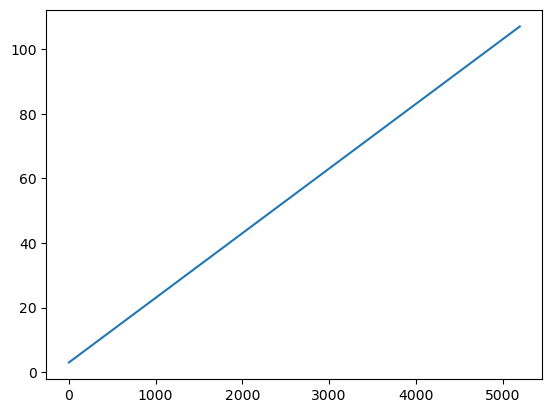

In [33]:
plt.plot(eve_data['wavelength'])
print(np.min(eve_data['wavelength']),np.max(eve_data['wavelength']))
# This version includes all measured wavelengths spanning 5.8 - 106.2 nm

In [6]:
wavelength_list_full=eve_data['wavelength']

In [35]:
eve_data=scipy.io.readsav(eve_full_files[400])
wavelength_list_full=eve_data['wavelength']

# Extracting the relevant data
a=eve_data['irradiance'][0]
t=time_converter(eve_data['yyyydoy'][0],eve_data['sod_time'][0])


# Creating a figure using Plotly Graph Objects
fig = go.Figure(data=go.Scatter(x=wavelength_list_full[:],y=a[:], mode='lines'))

fig.update_yaxes(#title_text="Stddev (nm)",
              range=[0, 0.006],
                )
fig.update_layout(title_text="EVE Irradiance"+'<br>'+t.strftime('%Y-%m-%d %H:%M:%S'),
                  xaxis_title="Wavelength (nm)",
                  yaxis_title="Irradiance (W/m^2/nm)",
                  )
# fig.write_html('output/full_band_spectrum/overview1.html')

In [36]:
# save into npz : wavelength_list_full,a
np.savez('output/full_band_spectrum/overview1.npz', wavelength_list_full=wavelength_list_full, a=a)


In [38]:
eve_data1=scipy.io.readsav(eve_full_files[400])
wavelength_list_full=eve_data['wavelength']

# Extracting the relevant data
a1=eve_data1['irradiance'][0]
t1=time_converter(eve_data1['yyyydoy'][0],eve_data1['sod_time'][0])


eve_data2=scipy.io.readsav(eve_full_files[11500])
wavelength_list_full=eve_data['wavelength']
# Extracting the relevant data
a2=eve_data2['irradiance'][0]
t2=time_converter(eve_data2['yyyydoy'][0],eve_data2['sod_time'][0])

# Creating a figure using Plotly Graph Objects
fig = go.Figure()
fig.add_trace(go.Scatter(x=wavelength_list_full[:],y=a1[:], 
                         mode='lines',
                         # set color rgba=(0,0,0,0.5)
                          line=dict(color='rgba(30,240,30,0.5)'),
                          # add a label of time
                          name=t1.strftime('%Y-%m-%d %H:%M:%S')
                         )
)
fig.add_trace(go.Scatter(x=wavelength_list_full[:],y=a2, 
                         mode='lines',
                         line=dict(color='rgba(240,30,30,0.5)'),
                          name=t2.strftime('%Y-%m-%d %H:%M:%S')
                          ),
),

fig.update_yaxes(#title_text="Stddev (nm)",
              range=[0, 0.006],
                )
fig.update_layout(title_text="EVE Irradiance",
                  xaxis_title="Wavelength (nm)",
                  yaxis_title="Irradiance (W/m^2/nm)",
                  )
fig.write_html('output/full_band_spectrum/overview2.html')
fig.show()

In [34]:
type(fig.layout.colorway)

NoneType

# Select Lines

In [2]:
# AIA lines 但是其中的很多不明显没法高斯拟合
lines=['Fe94', 'Fe131', 'Fe171', 'Fe193', 'Fe211', 'He304']
line_centers = [9.4, 13.1, 17.1, 19.3, 21.1, 30.4]


In [48]:
# Fe171
index1=np.where((wavelength_list_full<17.2)*(wavelength_list_full>17))

#


# 977
index2=np.where((wavelength_list_full<9.78)*(wavelength_list_full>9.76))




In [47]:
np.where((wavelength_list_full<3.2)*(wavelength_list_full>3.1))

(array([5, 6, 7, 8, 9], dtype=int64),)

In [51]:
aia_windows=[]
width=0.3
for wavelength in aia_wavelength:
    
    aia_window=[wavelength-width/2,wavelength+width/2]
    aia_windows.append(aia_window)

index_list=[]
for window in aia_windows[:]:
    # print(window)
    start,end=window
    index=np.where((start<wavelength_list_full)&(wavelength_list_full<end))[0]
    # print(index)
    index_list.append(index)
    
print(index_list)

[array([313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326], dtype=int64), array([498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510,
       511], dtype=int64), array([698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
       711], dtype=int64), array([808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820,
       821], dtype=int64), array([898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910,
       911], dtype=int64), array([1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373,
       1374, 1375, 1376], dtype=int64), array([1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528,
       1529, 1530, 1531], dtype=int64)]


In [43]:

index=np.where((start<wavelength_list_full)&(wavelength_list_full<end))[0]
index

array([900, 901, 902, 903, 904, 905, 906, 907, 908, 909], dtype=int64)

In [10]:
aia_wavelength=[9.4,13.1,17.1,19.3,21.1,30.4,33.5]
w=9.4
np.where((wavelength<w)&(w<wavelength+0.1))

(array([315, 316, 317, 318, 319], dtype=int64),)

In [15]:
np.where((wavelength<w)&(w<wavelength+0.1))

(array([315, 316, 317, 318, 319], dtype=int64),)

(array([ 320,  321,  322, ..., 5197, 5198, 5199], dtype=int64),)

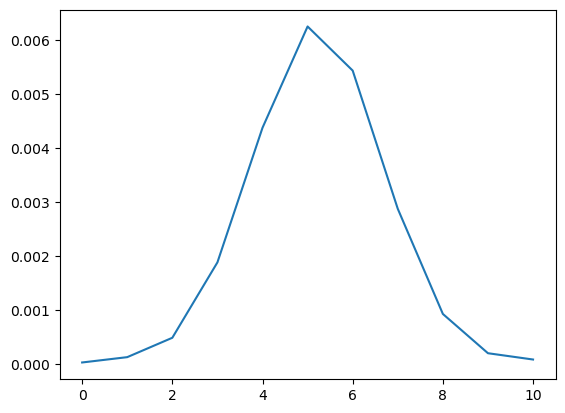

In [97]:
plt.plot(eve_data[10]['irradiance'][0][1363:1374])

In [99]:
wavelength[1363:1374]

array([30.27, 30.29, 30.31, 30.33, 30.35, 30.37, 30.39, 30.41, 30.43,
       30.45, 30.47], dtype='>f4')

In [43]:
# Extracting the relevant data
a=eve_data['irradiance'][0]
# Creating a figure using Plotly Graph Objects
fig = go.Figure(data=go.Scatter(x=wavelength_list_full,y=a, mode='lines'))

fig.update_yaxes(#title_text="Stddev (nm)",
              range=[0, 0.0013],
                )

fig.update_yaxes(title_text=r'$\rm{Irradiance}  \  ( W m^{-2} nm^{-1}  )$')
fig.update_xaxes(title_text="Wavelength (nm)")
fig.write_html('output//eve_full//spectrum.html')

In [36]:
eve_data.keys()

dict_keys(['wavelength', 'sod_time', 'irradiance', 'sc_flags', 'flags', 'yyyydoy'])

In [38]:
eve_data['yyyydoy'][0]

2010136

In [39]:
eve_data['sod_time'][0]

57603.29446601868